In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from scipy.special import softmax

from sklearn.metrics import precision_recall_curve, auc
import pickle
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,plot_confusion_matrix,multilabel_confusion_matrix
import dill
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt 

In [2]:
!pip install dill
!pip install imbalanced-learn
!pip install TensorBoard

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [4]:
otherannotation = pd.read_csv('data/comments_opinion_anno.csv')
add_opinoin=pd.Series(otherannotation.opinion.values, index=otherannotation.comments_id).to_dict()

In [5]:
### Reading csv data files using pandas dataframe 
alldata = pd.read_csv("data/file_with_post_annotated.csv")
# columns comment_text, comment_id, advice (other columns for annotation)
train_size = 0.8
train=alldata.sample(frac=train_size,random_state=200)
test_pred=alldata.drop(train.index).reset_index(drop=True)
train= train.reset_index(drop=True)
df=train
df=df.astype({"advice": int,'referral': int,
       'fact or situation appraisal': int, 'personal Experience': int, 'opinion': int,
       'emotional': int, 'others': int})
train.columns


<ipython-input-5-8a2dd9071a55>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remainingdata.dropna(subset=['comment_text'],inplace=True)


Index(['A/P', 'comments_id', 'comments_user', 'comment_text', 'advice',
       'referral', 'fact or situation appraisal', 'personal Experience',
       'opinion', 'emotional', 'others'],
      dtype='object')

In [6]:
len(alldata)

547

In [7]:
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [8]:
class TextEncodedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [9]:
def create_ds(df, tokenizer,column_name):
    labels = df[column_name].values
#     print(labels)
    text = df["comment_text"].tolist()
    encodings = tokenizer(text, truncation=True, padding=True)
    ds = TextEncodedDataset(encodings, labels)
    return ds

In [10]:

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [11]:
def evaluate(trainer, val_loader):
    res = trainer.prediction_loop(val_loader, description="Preds")
    logits = res[0]
    labels = res[1]
    pred_probas = softmax(logits, axis=1)[:, 1]
    precision, recall, thresholds = precision_recall_curve(labels, pred_probas)
    auc_score = auc(recall, precision)
    return {"auc_score": auc_score, "pos_samples": labels.sum()}

# Undersampling from  majority class

In [12]:
from imblearn.under_sampling import NearMiss
from collections import Counter
X_unlabel = remainingdata.copy()
X_unlabel=X_unlabel.astype({"advice": int,'referral': int,
       'fact or situation appraisal': int, 'personal Experience': int, 'opinion': int,
       'emotional': int, 'others': int})

X=X.astype({"advice": int,'referral': int,
       'fact or situation appraisal': int, 'personal Experience': int, 'opinion': int,
       'emotional': int, 'others': int})
column_name='opinion'
print('Random under-sampling:')
print(X[column_name].value_counts())
y=X[column_name].to_frame()
X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.3)

X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, stratify=y_test, test_size=0.5)

counter = Counter(y)
print(counter)
print(len(X_train),len(X_val),len(X_test))



Random under-sampling:
0    425
1    122
Name: opinion, dtype: int64
Counter({'opinion': 1})
382 83 82


In [13]:
X_train

,comment_text,advice,referral,fact or situation appraisal,personal Experience,opinion,emotional,others
816,I AM WRITING AS A 22 YEAR SURVIVOR OF OV CA AN...,0,0,1,1,1,0,0
183,I am glad you are searching out help on this s...,1,1,0,1,0,1,0
353,"Hi Penny, I was diagnosed 3c in February 2013....",0,0,0,1,0,0,0
6,Its my understanding that a clinical trial eva...,0,0,1,0,1,0,0
361,Yes I would. I would like to know if any of yo...,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...
795,Its very hard to know as we all respond differ...,1,1,1,0,1,0,0
257,"i do taxoterene on monday, f-5U pump for 48 ho...",0,0,1,1,0,1,0
164,Recently I was treated with Taxol for 11 weeks...,1,0,0,1,0,1,0
62,My sister has been diagnosed with Ovarian Canc...,0,0,0,1,1,0,0


[122, 751, 122, 85, 19, 18]


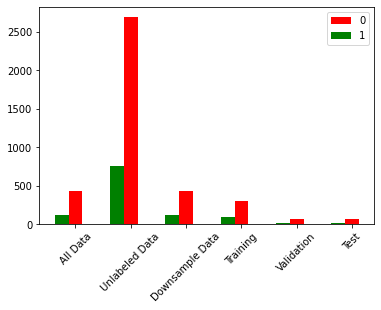

In [14]:
import numpy as np
import matplotlib.pyplot as plt
  
N = 6
ind = np.arange(N) 
width = 0.25
xvals=[]
yvals=[]
zvals=[]
for df_bar in [alldata,X_unlabel,X,X_train,X_val,X_test]:
    xvals.append(len(df_bar[df_bar[column_name] == 0]))
    yvals.append(len(df_bar[df_bar[column_name] == 1]))

bar1 = plt.bar(ind+width, xvals, width, color = 'r')
bar2 = plt.bar(ind, yvals, width, color='g')

print(yvals)
  
plt.xticks(ind+width,['All Data','Unlabeled Data', 'Downsample Data','Training','Validation','Test'],rotation=45)
plt.legend( (bar1, bar2), ('0', '1') )
plt.show()

In [15]:
for column_name in ['opinion']:
    print(len(X_train))
    val_ds = create_ds(X_val, tokenizer,column_name)
    val_loader = DataLoader(val_ds, batch_size=16, shuffle=True)

    pred_ds = create_ds(X_test,tokenizer,column_name)
    pred_loader = DataLoader(pred_ds, batch_size=16, shuffle=False)
    # n_sample_list = [ len(train_filt_full) ]#, 2000, 10000, 50000] #, 100000]

    train_dataset = create_ds(X_train, tokenizer,column_name)
    val_dataset = create_ds(X_val, tokenizer,column_name)
    pred_dataset =create_ds(X_test, tokenizer,column_name)


    n_samples = len(X_train)
    d_res = dict()
    #for n_samples in n_sample_list:
    print("Now running", n_samples)
    # train_filt = train_filt_full.sample(n_samples, random_state=0)
    # train_filt, test = train_test_split(train_filt, test_size=0.2, random_state=0)

    training_args = TrainingArguments(
        output_dir='./output_anno/output_inc//results_role/'+column_name.replace(" ","_"),          # output directory
        num_train_epochs=15,              # total number of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=64,   # batch size for evaluation
        warmup_steps=50,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        logging_dir='./output_anno/output_inc//logs_role/'+column_name.replace(" ","_"),            # directory for storing logs
        logging_steps=10,
        do_eval=True,
        do_predict=True,
        eval_steps=10,
        evaluation_strategy='steps',
        load_best_model_at_end=True,

    )

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    #logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=val_dataset   ,         # evaluation dataset
        compute_metrics=compute_metrics,
       #callbacks=[tensorboard_callback],
    )

    trainer.train()
    d_res[n_samples] = evaluate(trainer, val_loader)
    pred_test = list(X_test['comment_text'])
    pred_labels = list(y_test[column_name].astype(int))

    encodings = tokenizer(pred_test, truncation=True, padding=True)
    ds = TextEncodedDataset(encodings, pred_labels)
    res = trainer.predict(ds)
    # pred_dataset = create_ds(test_pred, tokenizer,column_name)
    # res = trainer.predict(pred_dataset)
    output=torch.argmax(torch.from_numpy(softmax(res.predictions, axis=1)),axis=1)
    score=f1_score(output,pred_labels)
    print(column_name,":")
    print("f1-score",score)
    print("precision",precision_score(output,pred_labels))
    print("recall",recall_score(output,pred_labels))
    print("accuracy", accuracy_score(output,pred_labels))
    print()
    # plot_confusion_matrix(clf, X_test, y_test) 
    plt.show()
    trainer.save_model('./output_anno/output_inc//results_role/'+column_name.replace(" ","_")+'/' + 'final_model.pt')

    with open("./output_anno/output_inc//results_role/"+column_name.replace(" ","_")+"/output_model_final.dill", "wb") as dill_file:
        dill.dump(trainer, dill_file)        



382
Now running 382


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

KeyboardInterrupt: 

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix( output,pred_labels) 


NameError: name 'output' is not defined

In [17]:
pred_test_2 = list(remainingdata['comment_text'])
pred_labels_2 = list(remainingdata[column_name].astype(int))

encodings = tokenizer(pred_test_2, truncation=True, padding=True)
ds = TextEncodedDataset(encodings, pred_labels_2)
res = trainer.predict(ds)

# pred_dataset = create_ds(test_pred, tokenizer,column_name)
# res = trainer.predict(pred_dataset)
output=torch.argmax(torch.from_numpy(softmax(res.predictions, axis=1)),axis=1)
remainingdata['advice_new']=output


NameError: name 'trainer' is not defined

In [18]:
score=f1_score(output,pred_labels_2)
print(column_name,":")
print("f1-score",score)
print("precision",precision_score(output,pred_labels_2))
print("recall",recall_score(output,pred_labels_2))
print("accuracy", accuracy_score(output,pred_labels_2))

opinion :
f1-score 0.6520065970313358
precision 0.7896138482023968
recall 0.5552434456928839
accuracy 0.8162020905923345


In [19]:
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [32]:
def infer(input_text,model):
    inputs = tokenizer(input_text,truncation=True, padding=True,return_tensors="pt")
#     inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
    
    labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss
    logits = outputs.logits
    classp = np.argmax(softmax(logits.detach().numpy()))
    return classp 

In [33]:
model = {}

for key in 
model = DistilBertForSequenceClassification.from_pretrained(
    './output_anno/final_models//'+column_name.replace(" ","_")+'/' + 'final_model.pt'    )
model.eval()

model_advice = DistilBertForSequenceClassification.from_pretrained(
    './output_anno//final_models/'+column_name.replace(" ","_")+'/' + 'final_model.pt'    )
model_advice.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
model_fact_or_

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [35]:
# pip install -U spacy
# python -m spacy download en_core_web_sm
import spacy

# Load English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

In [40]:
def sent_infer_opinion(input_text,model,model_advice):
    infer_list={}
    infer_list[0]=[]
    infer_list[1]=[]
    no_sent=True
    classp=0
    input_text = input_text.replace("\n"," ")
    for sent in list(nlp(str(input_text)).sents):
        if len(str(sent).strip().split(" ")) > 3:
            no_sent=False
            
            # advice 
            inputs_advice = tokenizer(str(sent),truncation=True, padding=True,return_tensors="pt")
            labels_advice = torch.tensor([1]).unsqueeze(0)  # Batch size 1
            outputs_advice = model_advice(**inputs_advice, labels=labels_advice)
            loss_advice = outputs_advice.loss
            logits_advice = outputs_advice.logits
            probs_advice=softmax(logits_advice.detach().numpy())
    #         print(probs)
            classp_advice = np.argmax(probs_advice)
            
            if classp_advice == 1:
                infer_list[classp].append(0)
                classp=0
                continue
            inputs = tokenizer(str(sent),truncation=True, padding=True,return_tensors="pt")
            labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs=softmax(logits.detach().numpy())
    #         print(probs)
            classp = np.argmax(probs)
            infer_list[classp].append(probs[0][classp])
#             print(str(sent),classp)
    classp=0
    if len(infer_list[1]) > 0:
        if max(infer_list[1]) > 0.60:
            classp=1
        else:
            classp = 0
        
    if no_sent==True:
        infer_list[0].append(1)
#     print(infer_list)
    return classp 

In [41]:
def sent_infer(input_text,model):
    infer_list={}
    infer_list[0]=[]
    infer_list[1]=[]
    no_sent=True
    classp=0
    input_text = input_text.replace("\n"," ")
    for sent in list(nlp(str(input_text)).sents):
        if len(str(sent).strip().split(" ")) > 3:
            no_sent=False
            
            # advice 
            inputs_advice = tokenizer(str(sent),truncation=True, padding=True,return_tensors="pt")
            labels_advice = torch.tensor([1]).unsqueeze(0)  # Batch size 1
            outputs_advice = model_advice(**inputs_advice, labels=labels_advice)
            loss_advice = outputs_advice.loss
            logits_advice = outputs_advice.logits
            probs_advice=softmax(logits_advice.detach().numpy())
    #         print(probs)
            classp_advice = np.argmax(probs_advice)
            
            if classp_advice == 1:
                infer_list[classp].append(0)
                classp=0
                continue
            inputs = tokenizer(str(sent),truncation=True, padding=True,return_tensors="pt")
            labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            probs=softmax(logits.detach().numpy())
    #         print(probs)
            classp = np.argmax(probs)
            infer_list[classp].append(probs[0][classp])
#             print(str(sent),classp)
    classp=0
    if len(infer_list[1]) > 0:
        if max(infer_list[1]) > 0.50:
            classp=1
        else:
            classp = 0
        
    if no_sent==True:
        infer_list[0].append(1)
#     print(infer_list)
    return classp 

In [42]:
def infer(input_text,model):
    inputs = tokenizer(input_text,truncation=True, padding=True,return_tensors="pt")
#     inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
    
    labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss
    logits = outputs.logits
    classp = np.argmax(softmax(logits.detach().numpy()))
    return classp 

In [37]:
df = pd.read_csv()
for index,row in X_test.iterrows():
#     print()
#     print("--- start ----")
#     print("comment_text",row['comment_text'])
#     print()
#     print("-- sentence wise result")
    pred=sent_infer(row['comment_text'],model,model_advice)
    output.append(pred)
#     print("-------------")
#     print("##real - prediction - ",row['opinion'],pred)
#     print("-------------")
#     print("-------end----------")

    

In [39]:
# output=X_test[column_name+"_pred_sent_output"  ].fillna(1)
pred_labels = list(X_test[column_name].astype(int))

score=f1_score(output,pred_labels)
print(column_name,":")
print("f1-score",score)
print("precision",precision_score(output,pred_labels))
print("recall",recall_score(output,pred_labels))
print("accuracy", accuracy_score(output,pred_labels))
print("confusion",confusion_matrix(output,pred_labels))

opinion :
f1-score 0.8076923076923077
precision 0.8076923076923077
recall 0.8076923076923077
accuracy 0.8780487804878049
confusion [[51  5]
 [ 5 21]]
